## Check simulations of BDs

In [2]:
import sys
sys.path.append("../python/")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh.palettes
import imp
from matplotlib.offsetbox import AnchoredText
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM

from matplotlib import rc
rc('font', family='times new roman', size=22.)

### Empirical space densities at the Solar neighbourhood

Data below is taken from Table 15 of [Kirkpatrick + '20](https://arxiv.org/abs/2011.11616)

In [3]:
# temperature [K]
bin_edges = [300, 450, 600, 750, 900, 1050, 1200, 1350, 1500, 1650, 1800, 1950, 2100, 2250] 
# space density [x 1e-3 pc-3]
rho       = [2.84, 4.24, 2.80, 1.99, 1.72, 1.11, 1.95, 0.94, 0.81, 0.78, 0.50, 0.72, 0.31] 
error_rho = [np.nan, 0.70, 0.37, 0.32, 0.30, 0.25, 0.30, 0.22, 0.20, 0.20, 0.17, 0.18, np.nan]

bins = np.zeros(len(rho))

for i in range(len(rho)):
    bins[i] = 0.5*(bin_edges[i] + bin_edges[i+1])

#TODO - need to plot arrows for lower limits

Text(0.5, 0, '$T_{\\rm eff}$ [K]')

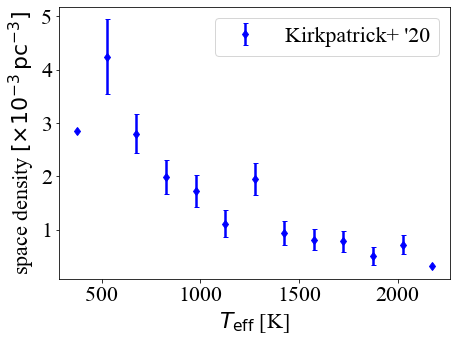

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.errorbar(bins, rho, error_rho, fmt="d", elinewidth=2.5, capsize=2.5, label="Kirkpatrick+ '20", color="blue")

ax.legend()
ax.set_ylabel(r"space density $\rm [\times 10^{-3}\,pc^{-3}]$")
ax.set_xlabel(r"$T_{\rm eff}$ [K]")